# Imports

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
from sklearn.covariance import GraphicalLassoCV,GraphicalLasso
from networkx.generators.community import gaussian_random_partition_graph
# from sklearn.inspection import ValidationCurveDisplay
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import glob as glob
import math

In [79]:
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = None
pd.options.display.max_columns = None

plt.style.use('ggplot')

# Setup 
Seed the random number generator once, so the entire notebook is reproducible.

In [80]:
np.random.seed(3)

## Load data
#### 1. A. Read ADNI data quartile csvs 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (103, 228) in low 
- (107, 228) in med low 
- (100, 228) in med high 
- (101, 228) in high 


In [81]:
#adni 
adni_cent_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_low_quartile.csv')
adni_cent_med_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_low_quartile.csv')
adni_cent_med_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_high_quartile.csv')
adni_cent_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_high_quartile.csv')


### 1. B. Read A4 data 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (101, 277) in low 
- (86, 277) in med low 
- (94, 277) in med high
- (92, 277) in high

In [82]:
#a4 
a4_cent_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_low_quartile.csv')
a4_cent_med_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_low_quartile.csv')
a4_cent_med_high = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_high_quartile.csv')
a4_cent_high = pd.read_csv('./a4/a4_adni_amy_tau_merged_cent_high_quartile.csv')

After this there are no more regions with zero volume:

In [83]:
zero_present = (a4_cent_high == 0).any().any()
print(zero_present)

False


For now let's drop `RID`, ` CENTILOIDS`, and `TRACER`  we don't need that information to compute the graph. Only keep the tau suvr values for the graph

In [84]:
a4_cent_low.head(5)

,RID,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,SUPERIORPARIETAL,LATERALOCCIPITAL,INFERIORPARIETAL,CAUDALANTERIORCINGULATE,POSTCENTRAL,CAUDATE,SUPRAMARGINAL,CENTILOIDS,PRECENTRAL,TEMPORALPOLE,PARACENTRAL,TRACER,ISTHMUSCINGULATE,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,B10709603,0.982,1.056,1.184,1.235,0.962,1.091,1.034,1.583,1.161,0.901,1.054,1.090,0.932,0.880,1.133,1.036,40.593,0.920,1.069,0.912,Florbetapir,1.055,1.395,1.037,1.719,1.276,1.030,1.184,1.019,1.118,0.898,1.040
1,B11089276,1.066,1.093,1.158,1.182,1.128,1.220,1.135,1.679,1.089,1.015,1.066,1.134,1.089,0.995,1.269,1.098,35.101,1.049,1.040,1.054,Florbetapir,1.097,1.426,1.119,1.741,1.238,1.159,1.268,1.128,1.161,1.049,1.160
2,B12755986,0.956,1.045,1.145,1.167,0.974,1.115,0.943,1.574,1.027,0.997,0.997,1.125,1.024,0.882,1.119,1.037,33.270,0.898,0.917,0.956,Florbetapir,1.041,1.452,0.943,1.800,1.236,1.098,1.145,0.962,1.122,0.908,1.069
3,B14928511,0.945,1.039,1.154,1.135,0.962,1.115,1.015,1.568,1.078,0.847,1.042,1.027,0.995,0.844,1.132,0.988,22.286,0.889,1.074,0.855,Florbetapir,1.080,1.418,1.019,1.651,1.224,1.099,1.162,0.988,1.123,0.843,1.007
4,B16052018,1.117,1.091,1.144,1.242,1.128,1.223,1.147,1.532,1.157,1.020,0.996,1.084,1.198,0.964,1.213,1.050,36.932,1.003,1.138,1.094,Florbetapir,1.107,1.316,1.112,1.626,1.255,1.194,1.228,1.119,1.110,1.116,1.165


In [85]:
#function to drop non regions 
def drop_nonregions(df):
    df = df.drop(['RID','CENTILOIDS','TRACER'], axis=1)
    return df 

In [86]:
#appy function to all dfs 
#a4
a4_cent_low = drop_nonregions(a4_cent_low)
a4_cent_med_low = drop_nonregions(a4_cent_med_low)
a4_cent_med_high = drop_nonregions(a4_cent_med_high)
a4_cent_high = drop_nonregions(a4_cent_high)
#adni 
adni_cent_low = drop_nonregions(adni_cent_low)
adni_cent_med_low = drop_nonregions(adni_cent_med_low)
adni_cent_med_high = drop_nonregions(adni_cent_med_high)
adni_cent_high = drop_nonregions(adni_cent_high)

## Normalize the data
Center the data and scale them to have unit standard deviation

In [89]:
#function to center data and scale them, and makesure format is a dataframe 
def norm(df):
    scaled_df = StandardScaler().set_output(transform='pandas').fit_transform(df)
    return scaled_df 

In [90]:
#appy norm function to all dfs 
#a4
a4_cent_low_norm = norm(a4_cent_low)
a4_cent_med_low_norm = norm(a4_cent_med_low)
a4_cent_med_high_norm = norm(a4_cent_med_high)
a4_cent_high_norm = norm(a4_cent_high)
#adni 
adni_cent_low_norm = norm(adni_cent_low)
adni_cent_med_low_norm = norm(adni_cent_med_low)
adni_cent_med_high_norm = norm(adni_cent_med_high)
adni_cent_high_norm = norm(adni_cent_high)

In [91]:
#check that the output is normalized 
a4_cent_low_norm.head(5)

,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,SUPERIORPARIETAL,LATERALOCCIPITAL,INFERIORPARIETAL,CAUDALANTERIORCINGULATE,POSTCENTRAL,CAUDATE,SUPRAMARGINAL,PRECENTRAL,TEMPORALPOLE,PARACENTRAL,ISTHMUSCINGULATE,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,-0.362242,-0.020505,-0.154581,0.769968,-1.912871,-0.214923,-0.851741,1.000949,0.695243,-1.478288,-0.271741,-0.267922,-1.629010,-1.181400,0.732571,-0.489030,-0.971604,-0.076255,-1.457696,-0.399593,1.051593,-0.509006,1.246207,0.561233,-0.428737,-0.088148,-0.848158,-0.459172,-1.183636,-0.977281
1,0.631055,0.511630,-0.486222,0.044200,0.277635,1.512546,0.489922,1.682351,-0.147111,-0.131370,-0.150657,0.217066,0.400310,0.370156,1.844215,0.290976,0.883470,-0.406167,0.287839,0.168081,1.300519,0.749003,1.387041,0.251660,1.192278,0.894569,0.514564,0.092622,0.806402,0.703288
2,-0.669691,-0.178708,-0.652042,-0.161206,-1.754521,0.106467,-2.060566,0.937068,-0.872470,-0.344041,-0.846894,0.117864,-0.439854,-1.154416,0.618137,-0.476449,-1.287973,-1.805449,-0.916826,-0.588818,1.509295,-1.951114,1.764731,0.235366,0.425751,-0.544410,-1.560774,-0.407843,-1.051846,-0.571144
3,-0.799765,-0.265000,-0.537244,-0.599406,-1.912871,0.106467,-1.104133,0.894480,-0.275803,-2.116302,-0.392826,-0.962337,-0.814697,-1.667104,0.724398,-1.092905,-1.417397,-0.019373,-2.158369,-0.061692,1.236280,-0.785154,0.810903,0.137606,0.438317,-0.345526,-1.235721,-0.395010,-1.908485,-1.439438
4,1.234128,0.482866,-0.664798,0.865824,0.277635,1.552720,0.649327,0.638955,0.648445,-0.072294,-0.856984,-0.334057,1.809200,-0.048090,1.386480,-0.312899,0.221971,0.708708,0.779539,0.303241,0.417234,0.641612,0.650865,0.390153,1.632088,0.426609,0.402046,-0.561832,1.689399,0.773311


Double checking there are no null values

In [95]:
def null_checker(df):
    null_count = df.isna().any().any()
    return null_count

In [103]:
#no null values
null_checker(adni_cent_high_norm)

False

## Create Bootstrap samples
- We use bootstrapping (with replacement) before the graphical lasso cv. 
- start with just a4_cent_low


In [105]:
num_bootstrap_samples = 100

bootstrap_precision_matrices = []
bootstrap_samples = []

for _ in tqdm(range(num_bootstrap_samples)):
    
    #sample with replacement
    bootstrap_sample = a4_cent_low_norm.sample(n=len(a4_cent_low_norm),replace=True).sort_index().reset_index(drop=True)
    
    bootstrap_samples.append(bootstrap_sample)

100%|██████████| 100/100 [00:00<00:00, 4924.57it/s]


Check for infinite and null values, the should both be false:

In [106]:
print(np.any(np.isinf(bootstrap_samples)))
print(bootstrap_sample.isna().any().any())

False
False


check datatypes 

if I give it alphas [1,10] it looks like it drops almost all of the connections 
   
How I can be evaluating how well my model is fitting the data?

2 matrices estimates (from graphical lasso and then the actual empirical) to do difference you could 

if I just want estimate of how well its performing 

- should we reset index?
- use the sklearn sampler?

## CV to select $L_1$ regularization

In [107]:
model = GraphicalLasso(alpha=0.1, max_iter=100, tol=1e-2, mode='cd',assume_centered=True,covariance=None) #if I predefine an alpha it will take less time 

model

TypeError: __init__() got an unexpected keyword argument 'covariance'

It looks like the model is very sensitive to the choice of $\alpha$, let's see what the sparsity looks like as a function of it

In [ ]:
alphas = np.geomspace(0.1,0.9,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in alphas: 
    
    model = GraphicalLasso(alpha=alpha, max_iter=200, tol=1e-2, mode='cd', assume_centered=True)
    model.fit(progs_norm)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

Choosing $\alpha$ < 0.2 has no effect on the sparsity of the covariance matrix (there might still be some shrinkage though). We should choose the optimal value of $\alpha$ by looking at the cross validated performance of the estimator, and thinking about how much sparsity we want in the final graph.

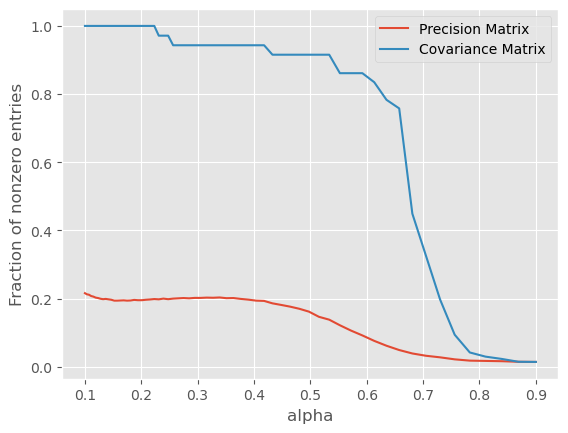

In [ ]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.legend();

In [ ]:
model.get_params()

{'alpha': 0.9,
 'assume_centered': True,
 'covariance': None,
 'enet_tol': 0.0001,
 'eps': 2.220446049250313e-16,
 'max_iter': 200,
 'mode': 'cd',
 'tol': 0.01,
 'verbose': False}

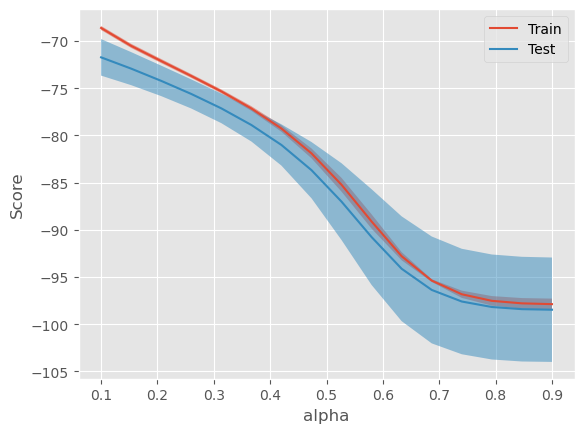

In [ ]:
ValidationCurveDisplay.from_estimator(estimator=model,
                                      X=progs_norm,
                                      y=None,
                                      cv=10,
                                      param_name='alpha',
                                      param_range=np.linspace(0.1,0.9,16),
                                      n_jobs=-1
                                     )

As expected, with increasing $\alpha$ our sparse approximation of the covariance matrix gets worse. 

- There's an inflection point around $\alpha = 0.5$, does it mean anything?
- At $\alpha=0.5$ the covariance matrix is still 90% filled, it might be a good idea to make it much more and then decrease alpha gradually if we cannot see any difference between the two groups.

# Train graphical model on bootstrapped sample 
find score on each num bootstrap sample 

In [ ]:
models = []

for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7,max_iter=150, tol=1e-3) #if I predefine an alpha it will take less time 
    
    model.fit(bootstrap_sample)
    models.append(model) 

100%|████████████████████████████████████| 100/100 [00:01<00:00, 60.52it/s]


In [ ]:
bootstrap_sample.head()

,vol_MidCinGy,vol_TemTraGy,vol_TemPo,vol_RecGy,vol_SupFroGy,vol_CbeWM,vol_Cun,vol_InfFroGy,vol_ParHipGy,vol_OccFusGy,vol_PosIns,vol_SCA,vol_CbrWM,vol_PCu,vol_Pla,vol_SupTemGy,vol_VenVen,vol_3thVen,vol_Pal,vol_MidOccGy,vol_MidTemGy,vol_PoCGy,vol_Tem,vol_PrcGy,vol_ThaPro,vol_MedOrbGy,vol_PosOrbGy,vol_Cal+Cbr,vol_Bst,vol_SupOccGy,vol_SupMarGy,vol_CbeLoCbe1-5,vol_AngGy,vol_MedPoCGy,vol_CSF,vol_MedPrcGy,vol_CenOpe,vol_ParOpe,vol_Cbr+Mot,vol_BasCbr+FobBr,vol_Acc,vol_AntOrbGy,vol_SupMedFroGy,vol_FroOpe,vol_OccPo,vol_Amy,vol_Ent,vol_InfTemGy,vol_InfFroAngGy,vol_AntIns,vol_LatVen,vol_CbeLoCbe8-10,vol_MedFroCbr,vol_InfFroOrbGy,vol_4thVen,vol_ExtCbe,vol_Cau,vol_Hip,vol_FroPo,vol_MidFroGy,vol_PosCinGy,vol_FusGy,vol_AntCinGy,vol_SupParLo,vol_Put,vol_InfOccGy,vol_LinGy,vol_CbeLoCbe6-7,vol_LatOrbGy
0,-0.683293,0.018276,0.555944,0.856272,-1.014610,-0.256159,-0.109963,-0.220731,1.041051,0.325436,-0.387923,0.201870,-1.026694,0.110560,0.001917,0.178390,-0.282887,-1.166501,-0.207089,1.227932,0.476224,-1.304988,-0.922757,-0.778716,-1.490251,0.000388,-0.229377,-1.445698,0.339727,-0.085427,-1.406009,0.218384,-0.443002,0.933152,0.203414,-0.367113,-0.980732,-1.950790,-0.714429,0.337425,-0.076164,0.307865,-0.501346,-0.437579,-0.960729,0.800738,1.567592,0.027199,0.320838,0.139186,-0.757352,0.346515,1.056985,-0.139677,-0.726048,0.800063,-0.712091,0.538197,-0.960818,-1.498817,-0.291151,0.405679,-0.046376,-1.439228,-0.051145,-0.201458,-0.013796,1.741973,0.731261
1,-1.022329,1.046900,0.815209,0.592287,-0.168692,-0.147598,-0.033782,0.791059,0.680099,-1.092481,0.823942,0.877083,-0.174558,-0.822806,0.054088,-0.689127,0.502199,0.194789,-0.975403,0.370403,0.009034,-0.009447,0.434829,0.091631,2.011594,0.704998,0.423149,2.739453,-0.554931,1.147535,-0.701236,1.743145,0.132270,-0.091763,-0.413224,-1.031451,-0.302104,-0.955589,-1.129644,1.474202,0.359821,0.950369,-0.294037,1.570071,1.146115,1.320171,0.629138,-0.228598,0.818653,2.557704,0.584410,-1.363815,0.093982,1.433535,-0.189490,0.310358,-0.467855,0.544833,0.801868,-0.495104,-0.713790,-0.859027,0.040495,-1.073168,1.500873,0.246857,-0.247062,0.882474,1.725542
2,-0.205211,0.553259,1.884267,0.658764,1.360374,-0.753145,1.323004,0.677160,1.515976,0.806363,1.896704,1.698567,-0.409906,0.469197,1.376829,1.745063,2.184066,2.256890,-0.340997,0.188360,1.560887,-0.460291,1.839119,0.754958,-0.662882,1.725487,1.865558,0.745347,-0.076298,1.278994,0.487760,-1.910760,0.389345,0.646116,-0.017263,0.474043,1.278223,2.373120,0.901273,1.144067,0.359009,3.560114,0.986113,1.402849,1.441560,1.126837,1.814254,2.100282,1.873032,1.909902,1.929666,-1.949071,1.319341,1.566543,-0.886163,-1.823967,-0.067662,1.015397,1.548433,1.416656,0.803251,1.822163,0.245578,-0.443678,0.538488,1.724002,1.243392,-1.487240,1.463364
3,-0.205211,0.553259,1.884267,0.658764,1.360374,-0.753145,1.323004,0.677160,1.515976,0.806363,1.896704,1.698567,-0.409906,0.469197,1.376829,1.745063,2.184066,2.256890,-0.340997,0.188360,1.560887,-0.460291,1.839119,0.754958,-0.662882,1.725487,1.865558,0.745347,-0.076298,1.278994,0.487760,-1.910760,0.389345,0.646116,-0.017263,0.474043,1.278223,2.373120,0.901273,1.144067,0.359009,3.560114,0.986113,1.402849,1.441560,1.126837,1.814254,2.100282,1.873032,1.909902,1.929666,-1.949071,1.319341,1.566543,-0.886163,-1.823967,-0.067662,1.015397,1.548433,1.416656,0.803251,1.822163,0.245578,-0.443678,0.538488,1.724002,1.243392,-1.487240,1.463364
4,-0.514499,-1.502178,-1.525877,-1.517090,-0.223188,-1.818510,-0.452985,-2.329257,-1.420365,-0.647440,-0.607835,-0.650063,2.258683,-0.243048,-1.856683,-1.384880,-1.828727,-1.373798,-1.024287,-0.666065,-1.654020,0.249962,-2.073908,-1.429799,-1.480152,-0.965424,-1.684620,-0.390330,-1.364385,0.186367,-1.681685,-0.187897,-0.883820,0.410803,-0.571943,-0.038697,-1.487852,-0.812690,0.874768,-1.185938,-0.456686,-0.797809,-0.107743,-1.737308,0.045141,-0.609469,-1.449322,-1.285696,-1.022308,-1.882026,-0.146766,-1.153905,-0.883951,-0.190038,-1.044344,-1.016338,1.542429,-0.639419,1.209035,-0.206869,-0.647454,-1.921640,-0

In [ ]:
#different metrics to calc 
#gpe, clus_coeff 
#density nx.density(G)
#eigenvector centrality nx.eigenvector_centrality(G) seems like its not a single value 
#assostivity coeff nx.degree_assortativity_coefficient(G) 
#diameter nx.diameter(G) -  Gives the diameter of the largest connected component in the graph, representing the longest shortest path between any pair of nodes. gave error 
#radius nx.radius - computes the radius of the largest connected compmenet gave error 
#number connected components nx.number_connected_components(G)

In [ ]:
#graphical lasso cv not converging 
#can adjust the tolerance, regularization parameter alphas, change solver method, increase max iterations, or random seed 
#example 
#model = GraphicalLassoCV(tol=1e-3)  # Increase tolerance level
#alphas = [0.1, 1.0, 10.0]  # Example list of alpha values to search
#model = GraphicalLassoCV(alphas=alphas)

#model = GraphicalLassoCV(solver='graph_lasso')  # Try a different solver
#model = GraphicalLassoCV(max_iter=500)  # Increase maximum iterations
#model = GraphicalLassoCV(random_state=42)  # Set a random seed
#graphical lasso -  WITHOUT BOOTSTRAP  
#converges with 500 iterations 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
# model = GraphicalLassoCV(cv=5,max_iter=500) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
# model.fit(progs_norm)
#have 1 rv per node (volumes), find out the optimization details, theorteically estimating corr mat of vars 


#have data, then unconnected random var,s est cov mat, and this estimation has penalty to force very small numbers to be 0 (force some sparsity) then interpret the inverse cov matrix as an adjacency matrix, and then visualize as a graph 
#makes sense to trat as random var, they are connecte din some sense if they are correlated 

#drop the very small nunvbwers, l1 sets very small things to 0, choses hyper parater by cross validation 

In [ ]:
#RuntimeWarning: invalid value encountered in subtract x = asanyarray(arr - arrmean) 
#check data for nan values 
nan_mask = progs_norm.isna()
nan_count = nan_mask.sum().sum()
print(nan_count)

#under the assumption the vars are gaussian and correlated oit is estimated cov matrix 
#plot histrogram (for one brain region)
#if you have random var that is sum of other random var, with finite variance, then CLT holds, if its the sum of many processed, then it's reasonably gaussian 


#for embeddings - sklearkn might have covariance betwen 2 random vars, use dot product of vectors instead of product 

0


In [ ]:
#just for graph visualization, doesn't work for bootstrapped because there's more than one pop graph 
#node size based on connectivity visualization 
#assigns node labels based on the column id 
#this doesn't work because it's the bootstrap sample list 
# precision_matrix_p = model.precision_
# np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

# G_prog = nx.Graph(precision_matrix_p)
# #create a dictionary that maps old node labels to new node labels
# node_labels = {i: label for i, label in enumerate(progs_norm.columns)}

# #relabel the nodes in the graph using the dictionary
# G_prog = nx.relabel_nodes(G_prog, node_labels)

# # Assuming you already have precision_matrix_np and G_n_prog as in your code
# # Calculate the node degrees (connectivity strength)
# node_degrees = dict(G_prog.degree())

# # Scale the node sizes based on node degrees
# node_sizes = [20 * node_degrees[node] for node in G_prog.nodes()]

# # Create a colormap for node colors based on node degrees
# node_colors = list(node_degrees.values())

# # Draw the graph with node sizes and colors
# pos = nx.random_layout(G_prog)
# nx.draw(
#     G_prog,
#     pos,
#     with_labels=True,
#     font_size=7,
#     style="dotted",
#     node_color=node_colors,
#     cmap=plt.cm.Reds,
#     node_size=node_sizes,
#     alpha=0.8,
#     width=0.3,
# )

# plt.title("Progressive MCI Population Graphical Model NACC", fontsize=22)
# plt.show()

#the random layout changes, to have the same one run the layout finctiopn first, choose what I want and then try it later 
#circular one might be good or spectral (bc it uses info on the degree of each node aware of hubs)
#since these are random seed rnadom generator to generate same layout 
#generate positions once and then pass same poisition dictioary 
#network x is generating citionary of 2d positins to draw function 
#draw in circle (then spot patterns that way)

In [ ]:
#calc metrics 
# terating through each bootsrap sample model, calculating the graph metrics, and then storing the metrics for eahc model in a dataframe 
metrics_data = []
#to get variance, 

#keep track of index with enumerate 
for model_num, model in enumerate(models,start=1):
    precision_matrix_p = model.precision_
    np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 
    G_prog = nx.Graph(precision_matrix_p)
    node_labels = {i: label for i, label in enumerate(progs_norm.columns)}
    #relabel the nodes in the graph using the dictionary
    G_prog = nx.relabel_nodes(G_prog, node_labels)
    #now calculate the metrics and store them 
    gpe = nx.global_efficiency(G_prog) 
    clustering_coefficient = nx.average_clustering(G_prog)
    density = nx.density(G_prog)
    # eigen_cen = nx.eigenvector_centrality(G_prog)
    ass_coeff = nx.degree_assortativity_coefficient(G_prog)
    # diameter = nx.diameter(G_prog)
    # radius = nx.radius(G_prog)


    #create dictionary for current models data 
    metrics_dic = {
        'model_num': model_num,
        'gpe': gpe,
        'clus_coeff':clustering_coefficient,
        'density': density,
        'ass_coeff': ass_coeff
    }
    metrics_data.append(metrics_dic)


#turn the list of dictionaries with each model info into a df
metrics_data = pd.DataFrame(metrics_data)
metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/full_bootstrap_models_prog_metrics.csv')
# print(metrics_data.dtypes)
print(metrics_data)

    model_num       gpe  clus_coeff   density  ass_coeff
0           1  0.553602    0.370794  0.182438   0.110434
1           2  0.550512    0.365708  0.177749   0.098946
2           3  0.528097    0.374630  0.173061   0.181385
3           4  0.541610    0.372543  0.172208   0.082564
4           5  0.549623    0.331372  0.173487   0.078874
5           6  0.531614    0.367883  0.167093   0.206226
6           7  0.554703    0.344162  0.179881   0.126351
7           8  0.560742    0.341407  0.187980   0.139487
8           9  0.548274    0.359104  0.175618   0.016902
9          10  0.543016    0.372295  0.174766   0.052620
10         11  0.553247    0.362236  0.177323   0.122569
11         12  0.554561    0.383884  0.182012   0.191895
12         13  0.547670    0.315926  0.171355   0.131529
13         14  0.551506    0.342595  0.176471   0.107751
14         15  0.545290    0.338062  0.170503   0.099214
15         16  0.558397    0.373119  0.189258   0.179240
16         17  0.558717    0.38

In [ ]:
#print(metrics_data)
#calc variance for each metric (which is col for each) like for mean 
#plot the variance for each metric/col across diff num samples (training curve)
# sklearn has training curve display 
# do it on estimator (graph lasso cv and training set) but do it on pop_ggm_code without bootstrap (good to have on poster)
# on bootstrapped data SSE ()

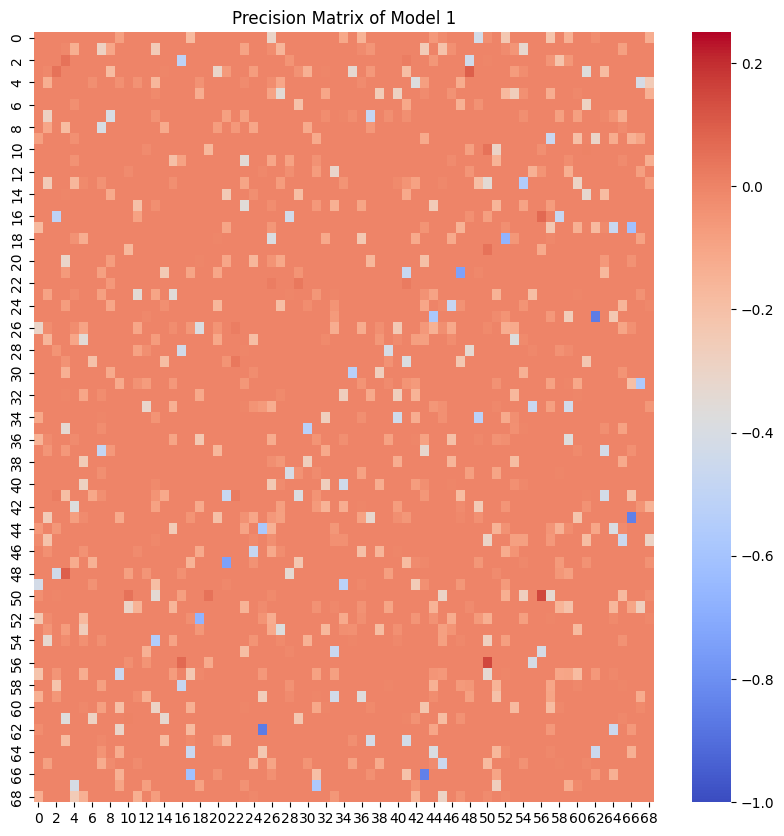

-0.8613172479589141 0.1515223421533196


In [ ]:
#heatmap of precision matrix (precision matrix is the inverse of the covariance matrix)

# Assuming models is your list of models
model_num = 0  # Change this to get the precision matrix of other models
precision_matrix = models[model_num].precision_

# Set the diagonal to zero if desired
np.fill_diagonal(precision_matrix, 0)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(precision_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=.25)  # assuming values range from -1 to 1
plt.title(f'Precision Matrix of Model {model_num + 1}')
plt.show()
print(np.min(precision_matrix), np.max(precision_matrix))

#stronger parital correlation is red but what if 


In [ ]:
#run bootstrap for stable df 
# np.random.seed(3)
stab_num_bootstrap_samples = 50
stab_bootstrap_precision_matrices = []
stab_bootstrap_samples = []
for x in range(stab_num_bootstrap_samples):
    #sample with replacement, randomstate =1 for reporoducibility 
    stab_bootstrap_sample = stable_norm.sample(n=len(stable_norm),replace=True)
    #append resamples df to a list 
    stab_bootstrap_samples.append(stab_bootstrap_sample)

In [ ]:
# #bootstrap and plot stable 
# #bootstrap for stable adni 
# stab_num_bootstrap_samples = 5 
# stab_bootstrap_precision_matrices = []
# stab_bootstrap_samples = []
# for x in range(stab_num_bootstrap_samples):
#     #sample with replacement, randomstate =1 for reporoducibility 
#     stab_bootstrap_sample = stable_norm.sample(n=len(stable_norm),replace=True, random_state=1)
#     #append resamples df to a list 
#     stab_bootstrap_samples.append(stab_bootstrap_sample)

In [ ]:
#run graphical model on bootstrapped sample 
stab_models = []
for stab_bootstrap_sample in tqdm(stab_bootstrap_samples):
    #if I give it alphas [1,10] it looks like it drops almost all of the connections 
    
    stab_model = GraphicalLassoCV(cv=5,max_iter=50,tol=1e-3)
    stab_model.fit(stab_bootstrap_sample)
    stab_models.append(stab_model) 

  0%|          | 0/100 [00:00<?, ?it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
  1%|          | 1/100 [00:00<00:55,  1.78it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
  2%|▏         | 2/100 [00:01<00:55,  1.78it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages

In [ ]:
# stab_models.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/full_bootstrap_models_stab.csv')
#this doesn't work because the bootstrap is a list 

In [ ]:
#check that the bootstrap values are unique 
stab_bootstrap_samples[1].index.nunique()

235

In [ ]:
# #plot graph just for viualization doesn't work if there are more than one 
# #this doesn't work because the fraph is 
# precision_matrix_s = stab_model.precision_
# np.fill_diagonal(precision_matrix_s, 0) #removes self connections by replacing the diagnonal of matrix with 0 

# G_stab = nx.Graph(precision_matrix_s)
# #create a dictionary that maps old node labels to new node labels
# node_labels = {i: label for i, label in enumerate(stable_norm.columns)}

# #relabel the nodes in the graph using the dictionary
# G_stab = nx.relabel_nodes(G_stab, node_labels)

# #visualize the relabeled graph
# pos = nx.random_layout(G_stab)
# nx.draw(G_stab, pos, with_labels=True, font_size=7, style="dotted",
#         node_color=range(len(G_stab)), cmap=plt.cm.Blues,
#         node_size=150*len(G_stab)/154, alpha=.8, width=.3)
# plt.title("Stable MCI Population Graphical Model ADNI", fontsize=22)
# plt.show()

In [ ]:
# Assuming stable_norm and stab_models are already defined somewhere

stab_metrics_data = []

for stab_model_num, stab_model in enumerate(stab_models):
    precision_matrix_stab = stab_model.precision_
    np.fill_diagonal(precision_matrix_stab, 0)  # removes self connections by replacing the diagonal of matrix with 0
    G_stab = nx.Graph(precision_matrix_stab)
    # create a dictionary that maps old node labels to new node labels
    stab_node_labels = {i: label for i, label in enumerate(stable_norm.columns)}
    # relabel the nodes in the graph using the dictionary
    G_stab = nx.relabel_nodes(G_stab, stab_node_labels)
    # now calculate the metrics and store them
    stab_gpe = nx.global_efficiency(G_stab)
    stab_clustering_coefficient = nx.average_clustering(G_stab)

    # Assuming you want to store metrics for stab (stability) models,
    # not prog (progression) models as shown in the second snippet
    stab_density = nx.density(G_stab)
    stab_ass_coeff = nx.degree_assortativity_coefficient(G_stab)

    # metrics dictionary
    stab_metrics_dic = {'model_num': stab_model_num,
                        'gpe': stab_gpe,
                        'clus_coeff': stab_clustering_coefficient,
                        'density': stab_density,
                        'ass_coeff': stab_ass_coeff
                        }

    stab_metrics_data.append(stab_metrics_dic)

stab_metrics_data = pd.DataFrame(stab_metrics_data)
stab_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_stab_metrics.csv')
print(stab_metrics_data)


    model_num       gpe  clus_coeff   density  ass_coeff
0           0  0.535450    0.438925  0.186275   0.185154
1           1  0.540153    0.416321  0.202899   0.159723
2           2  0.536587    0.441913  0.196505   0.139782
3           3  0.538456    0.452660  0.196505   0.257861
4           4  0.542661    0.411674  0.195226   0.223032
5           5  0.542164    0.424715  0.196505   0.193139
6           6  0.551080    0.423725  0.201194   0.211676
7           7  0.548068    0.424991  0.191816   0.206396
8           8  0.560919    0.456230  0.204604   0.220611
9           9  0.556969    0.428390  0.202899   0.200333
10         10  0.529909    0.442961  0.194800   0.167151
11         11  0.541226    0.433844  0.197357   0.231115
12         12  0.541468    0.434945  0.207161   0.130228
13         13  0.530548    0.406330  0.193947   0.225398
14         14  0.548806    0.452319  0.201194   0.164409
15         15  0.546384    0.467120  0.192242   0.210902
16         16  0.542484    0.42

In [ ]:
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

for col in metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        progs_data = metrics_data[col]
        stab_data = stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(progs_data, stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
results_df['Significant'] = results_df['P-Value'] < 0.05

# Display or save the results
print(results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#the resulting negative t stats mean the progs have lower volume than the stab which is good 
results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest.csv')


  Brain Region  T-Statistic       P-Value  Significant
0          gpe     4.459436  1.377351e-05         True
1   clus_coeff   -24.185478  5.628139e-56         True
2      density   -17.855201  2.327898e-42         True
3    ass_coeff    -8.512191  1.000996e-14         True


Interpreting t test results:
1. GPE was lower for progressive MCI
-Global path effiency is a measure of the effiency of information exchange across the network, a lower efficency indicates that the graph network is not effiently structured and that information has to travel more indirectly between nodes 

2. clustering coefficent was lower for progressive MCI
- Clustering coefficient is extent to which nodes in a graph are organized into clusters. 
- Specifically, the average clustering coefficient calculates the mean of local clustering coefficients of all the vertices in the network. A higher clustering coefficient indicates a higher degree of clustering in the network.

3. Graph density was lower for progressive MCI 
- density is a measure of how closely knit the network is (low density value is a more sparse network)

4. Assortivity coefficient was lower for progressive MCI 
- correlation coefficient for degrees of connected nodes 
- lower assortativity is indicates that nodes with a high degree tend to connect with nodes of low degree (dissasortive mixing)

In [ ]:
# #now try for nacc 
# comb_gmv_nacc = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/graph_gmv_volumes/mike_gmv_nacc_combo.csv")
# comb_gmv_nacc = comb_gmv_nacc.drop(['Unnamed: 0'], axis=1)
# print(comb_gmv_nacc.dtypes)

RID                   object
TIV                  float64
vol_l3thVen          float64
vol_r3thVen          float64
vol_l4thVen          float64
vol_r4thVen          float64
vol_lAcc             float64
vol_rAcc             float64
vol_lAmy             float64
vol_rAmy             float64
vol_lBst             float64
vol_rBst             float64
vol_lCau             float64
vol_rCau             float64
vol_lExtCbe          float64
vol_rExtCbe          float64
vol_lCbeWM           float64
vol_rCbeWM           float64
vol_lCbrWM           float64
vol_rCbrWM           float64
vol_lCSF             float64
vol_rCSF             float64
vol_lHip             float64
vol_rHip             float64
vol_lInfLatVen       float64
vol_rInfLatVen       float64
vol_lLatVen          float64
vol_rLatVen          float64
vol_lPal             float64
vol_rPal             float64
vol_lPut             float64
vol_rPut             float64
vol_lThaPro          float64
vol_rThaPro          float64
vol_lVenVen   

In [ ]:
nacc_prog_rids = pd.read_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_vol.csv")
nacc_stab_rids = pd.read_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_vol.csv")
# print(nacc_prog_rids)

In [ ]:
nacc_prog_rids = nacc_prog_rids.drop(['Unnamed: 0'], axis=1) #drop col 
nacc_stab_rids = nacc_stab_rids.drop(['Unnamed: 0'],axis=1)
# print(nacc_stab_rids.dtypes)

In [ ]:
print(nacc_stab_rids.dtypes)

RID           object
PROGRESSES     int64
1              int64
2              int64
3              int64
4              int64
5              int64
6              int64
7              int64
8              int64
9              int64
10             int64
11             int64
12             int64
13             int64
14             int64
15             int64
16             int64
17             int64
18             int64
19             int64
20             int64
21             int64
22             int64
23             int64
24             int64
25             int64
26             int64
27             int64
28             int64
29             int64
30             int64
31             int64
32             int64
33             int64
34             int64
35             int64
36             int64
37             int64
38             int64
39             int64
40             int64
41             int64
42             int64
43             int64
44             int64
45             int64
46           

In [ ]:
#stratify them into prog and stable for nacc 
#double check these are correct 

#do this by cross referencing the stable dfs that I have before from other csv files 
#these are all object datatype so hopefull it will work without converting them to int 

# nacc_prog_rids['RID'] = nacc_prog_rids["RID"].astype('int64')
# nacc_stable_rids['RID']=nacc_stable_rids['RID'].astype('int64')
# comb_gmv_nacc['RID']=comb_gmv_nacc['RID'].astype('int64')

rid_comb_gmv = set(comb_gmv_nacc["RID"])
rid_nacc_prog = set(nacc_prog_rids['RID'])
rid_nacc_stab = set(nacc_stab_rids['RID'])


nacc_gmv_prog = pd.DataFrame()
nacc_gmv_stab = pd.DataFrame()


#itterows allows you to iterate through rows of a df (it returns an iterator which is a pairs of index and series (the data for that row) for each row)
for index, row in comb_gmv_nacc.iterrows():
    rid = row["RID"]

    if rid in rid_nacc_prog:
        #if that rid exists in adni_progs then append the row to adni_gmv
        nacc_gmv_prog = nacc_gmv_prog.append(row,ignore_index=True)
    else:  
        nacc_gmv_stab = nacc_gmv_stab.append(row,ignore_index=True) #if they arent prog they are stab 

print(nacc_gmv_stab)

            RID          TIV  vol_l3thVen  vol_r3thVen  vol_l4thVen  \
0    NACC000511  1555.177037     0.020264     0.013338     0.053174   
1    NACC000531  1647.584787     0.067283     0.052440     0.099190   
2    NACC003196  1362.881871     0.022565     0.022337     0.051906   
3    NACC006009  1409.219319     0.051523     0.050538     0.053296   
4    NACC006420  1323.345298     0.062451     0.058506     0.084043   
5    NACC008987  1478.138655     0.021388     0.009847     0.054729   
6    NACC013585  1683.455180     0.022341     0.019690     0.081929   
7    NACC015412  1588.981310     0.038149     0.025824     0.093200   
8    NACC015899  1385.628810     0.011388     0.010145     0.103969   
9    NACC016502  1558.432298     0.040541     0.032090     0.095408   
10   NACC018906  1440.794848     0.021863     0.025353     0.046620   
11   NACC019767  1455.519980     0.042957     0.033051     0.057031   
12   NACC022572  1420.393624     0.019902     0.010902     0.063051   
13   N

In [ ]:
#nacc_gmv_prog 
nacc_gmv_prog = nacc_gmv_prog.drop(['RID','TIV','Dataset'], axis=1)
nacc_gmv_stab = nacc_gmv_stab.drop(['RID','TIV','Dataset'], axis=1)

In [ ]:
#drop regions with 0 volume 
nacc_gmv_prog = nacc_gmv_prog.drop(['vol_lInfLatVen','vol_rInfLatVen','vol_lOC','vol_rOC'], axis=1)
nacc_gmv_stab = nacc_gmv_stab.drop(['vol_lInfLatVen','vol_rInfLatVen','vol_lOC','vol_rOC'],axis=1)

In [ ]:
#check nacc gmv prog for 0 values

# Assuming nacc_gmv_prog is your dataframe
zero_values = (nacc_gmv_prog == 0).sum().sum()

print(f'Total zero values in the DataFrame: {zero_values}')



Total zero values in the DataFrame: 0


In [ ]:
# print(nacc_gmv_stab)

In [ ]:
#I guess scale the data like from original code because it involves distance metric 
#have to do standard scalar normalization 
#it normalizes by column 
#sklearn standard scalar 
scaler = StandardScaler()
#fit to your data and apply the transformation to your data 
nacc_progs_norm = scaler.fit_transform(nacc_gmv_prog)
nacc_stable_norm = scaler.fit_transform(nacc_gmv_stab)
print(nacc_progs_norm.shape)
print(nacc_progs_norm)

(130, 138)
[[ 0.80534502  0.80672542 -1.21281711 ... -1.56645865 -0.18369921
   0.18699365]
 [-1.0017424  -1.37379319 -0.98761321 ... -1.44887849 -1.0843805
  -0.86821437]
 [ 0.64304712  1.26303585  3.21863655 ...  0.21128954  0.63693679
   0.67087137]
 ...
 [-0.34222146  0.20341642 -1.53052567 ... -0.72510253 -0.38928224
  -0.68852892]
 [ 0.58160352  0.84561378 -0.63813427 ...  0.60840074 -0.16031015
  -0.83746145]
 [ 0.66632273 -0.16109067 -1.34600651 ... -0.20006617 -0.85137123
  -1.09630316]]


In [ ]:
#the output of standard scaler is a numpy array so need to reconvert it 
nacc_progs_norm = pd.DataFrame(nacc_progs_norm, columns=nacc_gmv_prog.columns)
nacc_stable_norm = pd.DataFrame(nacc_stable_norm,columns=nacc_gmv_stab.columns)
print(progs_norm)

     vol_PosOrbGy  vol_CenOpe  vol_CbeLoCbe6-7   vol_PCu  vol_FroOpe  \
0       -0.428600   -0.744751        -0.244645 -1.768431   -1.092651   
1       -0.229377   -0.980732         1.741973  0.110560   -0.437579   
2       -0.051732   -0.121082         0.345323  0.629202   -0.882547   
3        0.718910    0.200415         1.178565  0.891721    0.182375   
4        0.588957    1.814637         0.115175  1.681490    1.481053   
5       -1.123131   -0.788088        -0.132663  0.561288    0.132334   
6       -0.399634   -1.424167        -1.099012  0.057530   -0.935879   
7        0.423149   -0.302104         0.882474 -0.822806    1.570071   
8        1.865558    1.278223        -1.487240  0.469197    1.402849   
9       -0.394046   -0.769570         0.325537 -0.254741   -0.033088   
10      -1.684620   -1.487852        -0.309322 -0.243048   -1.737308   
11      -0.344655   -0.161681        -1.344897  0.198750    0.175861   
12      -0.388598   -0.460448        -1.229130  0.307711   -1.26

In [ ]:
print(nacc_progs_norm.isnull().sum().sum())  # Sum of NaN values
print(nacc_progs_norm.isin([np.inf, -np.inf]).sum().sum())  # Sum of Inf values


0
0


In [ ]:
#check nacc gmv prog for 0 values

# Assuming nacc_gmv_prog is your dataframe
zero_values = (nacc_progs_norm == 0).sum().sum()

print(f'Total zero values in the DataFrame: {zero_values}')


Total zero values in the DataFrame: 0


In [ ]:
nan_mask = nacc_progs_norm.isna()
nan_count = nan_mask.sum().sum()
print(nan_count)

0


In [ ]:
assert not nacc_progs_norm.isnull().values.any(), "Initial DataFrame has NaN values"
assert not np.isinf(nacc_progs_norm).values.any(), "Initial DataFrame has Inf values"


In [ ]:
#run bootstrapping (with replacement) before the graphical lasso cv () 
#random_state = None means random number generator is inistalized, produces different set of rnadom samples each time 
#setting random state to 1 so that its reproducable 

#set random generator outside loop 
#seed everytrhing once at begibning and dont touch it 
# np.random.seed(1)


num_bootstrap_samples = 50
nacc_bootstrap_precision_matrices = []
nacc_bootstrap_samples = []
for x in range(num_bootstrap_samples):
    #sample with replacement, randomstate =1 for reporoducibility 
    nacc_bootstrap_sample = nacc_progs_norm.sample(n=len(nacc_progs_norm),replace=True)
    #append resamples df to a list 
    nacc_bootstrap_samples.append(nacc_bootstrap_sample)


In [ ]:
print(nacc_bootstrap_sample.dtypes)


vol_l3thVen          float64
vol_r3thVen          float64
vol_l4thVen          float64
vol_r4thVen          float64
vol_lAcc             float64
vol_rAcc             float64
vol_lAmy             float64
vol_rAmy             float64
vol_lBst             float64
vol_rBst             float64
vol_lCau             float64
vol_rCau             float64
vol_lExtCbe          float64
vol_rExtCbe          float64
vol_lCbeWM           float64
vol_rCbeWM           float64
vol_lCbrWM           float64
vol_rCbrWM           float64
vol_lCSF             float64
vol_rCSF             float64
vol_lHip             float64
vol_rHip             float64
vol_lLatVen          float64
vol_rLatVen          float64
vol_lPal             float64
vol_rPal             float64
vol_lPut             float64
vol_rPut             float64
vol_lThaPro          float64
vol_rThaPro          float64
vol_lVenVen          float64
vol_rVenVen          float64
vol_lCbeLoCbe1-5     float64
vol_rCbeLoCbe1-5     float64
vol_lCbeLoCbe6

In [ ]:
# Check that all dataframes have the same datatypes for each column
datatypes = nacc_bootstrap_samples[0].dtypes  # Get datatypes of the first dataframe
same_datatypes = all((df.dtypes == datatypes).all() for df in nacc_bootstrap_samples)

print(f'All dataframes have the same datatypes for each column: {same_datatypes}')


All dataframes have the same datatypes for each column: True


In [ ]:


# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if df.isnull().values.any():
        print(f'NaN values found in DataFrame at index {i}')
    else:
        print(f'No NaN values found in DataFrame at index {i}')

# If you want to see the total count of NaN values across all DataFrames:
total_nan_count = sum(df.isnull().sum().sum() for df in nacc_bootstrap_samples)
print(f'Total NaN count across all DataFrames: {total_nan_count}')


No NaN values found in DataFrame at index 0
No NaN values found in DataFrame at index 1
No NaN values found in DataFrame at index 2
No NaN values found in DataFrame at index 3
No NaN values found in DataFrame at index 4
No NaN values found in DataFrame at index 5
No NaN values found in DataFrame at index 6
No NaN values found in DataFrame at index 7
No NaN values found in DataFrame at index 8
No NaN values found in DataFrame at index 9
No NaN values found in DataFrame at index 10
No NaN values found in DataFrame at index 11
No NaN values found in DataFrame at index 12
No NaN values found in DataFrame at index 13
No NaN values found in DataFrame at index 14
No NaN values found in DataFrame at index 15
No NaN values found in DataFrame at index 16
No NaN values found in DataFrame at index 17
No NaN values found in DataFrame at index 18
No NaN values found in DataFrame at index 19
No NaN values found in DataFrame at index 20
No NaN values found in DataFrame at index 21
No NaN values found 

In [ ]:
import pandas as pd
import numpy as np

# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if np.isinf(df).values.any():
        print(f'Infinite values found in DataFrame at index {i}')
    else:
        print(f'No infinite values found in DataFrame at index {i}')

# If you want to see the total count of infinite values across all DataFrames:
total_inf_count = sum(np.isinf(df).sum().sum() for df in nacc_bootstrap_samples)
print(f'Total infinite count across all DataFrames: {total_inf_count}')


No infinite values found in DataFrame at index 0
No infinite values found in DataFrame at index 1
No infinite values found in DataFrame at index 2
No infinite values found in DataFrame at index 3
No infinite values found in DataFrame at index 4
No infinite values found in DataFrame at index 5
No infinite values found in DataFrame at index 6
No infinite values found in DataFrame at index 7
No infinite values found in DataFrame at index 8
No infinite values found in DataFrame at index 9
No infinite values found in DataFrame at index 10
No infinite values found in DataFrame at index 11
No infinite values found in DataFrame at index 12
No infinite values found in DataFrame at index 13
No infinite values found in DataFrame at index 14
No infinite values found in DataFrame at index 15
No infinite values found in DataFrame at index 16
No infinite values found in DataFrame at index 17
No infinite values found in DataFrame at index 18
No infinite values found in DataFrame at index 19
No infinit

In [ ]:
# for index, value in enumerate(nacc_bootstrap_samples):
#     if math.isnan(value):
#         print(f'NaN found at index {index}')

In [ ]:
#run graphical model on bootstrapped sample 
#it worked changing the random seed so fingers crossed 
#setting random seed to 3 changed it so it wasn't generating sample with inf or nan values 
#setting random seed as 3 and 100 samples works 
nacc_models = []
for nacc_bootstrap_sample in tqdm(nacc_bootstrap_samples):
    nacc_model = GraphicalLassoCV(cv=5,max_iter=50, tol=1e-3)
    nacc_model.fit(nacc_bootstrap_sample)
    nacc_models.append(nacc_model) 

#error that it must not contain infs or nans 

  0%|          | 0/50 [00:00<?, ?it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
  2%|▏         | 1/50 [07:17<5:57:13, 437.42s/it]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages

KeyboardInterrupt: 

In [ ]:
# #check for nan or inf values - dont need anymore since I fixed it 

# #I don't need to use this because the 100 samples + random seed 3 is good without it 
# nacc_models = []
# for nacc_bootstrap_sample in tqdm(nacc_bootstrap_samples):
#     if nacc_bootstrap_sample.isnull().values.any() or np.isinf(nacc_bootstrap_sample).values.any():
#         print('NaN or Inf found')
#     nacc_model = GraphicalLassoCV(cv=2,max_iter=50, tol=1e-3)
#     nacc_model.fit(nacc_bootstrap_sample)
#     nacc_models.append(nacc_model)

# #try logging 
# import logging
# logging.basicConfig(level=logging.INFO)


# nacc_models = []
# for idx, nacc_bootstrap_sample in enumerate(tqdm(nacc_bootstrap_samples)):
#     # Check for NaN/Inf values
#     if nacc_bootstrap_sample.isnull().values.any() or np.isinf(nacc_bootstrap_sample).values.any():
#         logging.info(f'NaN or Inf found in sample {idx}')

#     # Try to fit the model
#     #try and except block structure 
#     try:
#         nacc_model = GraphicalLassoCV(cv=2, max_iter=50, tol=1e-3)
#         nacc_model.fit(nacc_bootstrap_sample)
#         nacc_models.append(nacc_model)
#     except ValueError as e:
#         logging.error(f'Error encountered in sample {idx}: {e}')
#         logging.error(f'Data: {nacc_bootstrap_sample}')



In [ ]:
# # need anymore I fixed the issue 
# import logging
# from tqdm import tqdm
# import pandas as pd
# from sklearn.covariance import GraphicalLassoCV

# logging.basicConfig(level=logging.INFO)

# nacc_models = []
# for idx, nacc_bootstrap_sample in enumerate(tqdm(nacc_bootstrap_samples)):
#     # Locate NaN and Inf values
#     nan_locations = nacc_bootstrap_sample.isnull().stack()[lambda x: x]
#     inf_locations = nacc_bootstrap_sample.isin([np.inf, -np.inf]).stack()[lambda x: x]

#     if not nan_locations.empty or not inf_locations.empty:
#         logging.info(f'NaN or Inf found in sample {idx}')
#         for location in nan_locations.index:
#             logging.info(f'NaN found at row {location[0]}, column {location[1]}')
#         for location in inf_locations.index:
#             logging.info(f'Inf found at row {location[0]}, column {location[1]}')

#     # Try to fit the model
#     try:
#         nacc_model = GraphicalLassoCV(cv=2, max_iter=50, tol=1e-3)
#         nacc_model.fit(nacc_bootstrap_sample)
#         nacc_models.append(nacc_model)
#     except ValueError as e:
#         logging.error(f'Error encountered in sample {idx}: {e}')
#         logging.error(f'Data: {nacc_bootstrap_sample}')


In [ ]:
#so there is one model that is throwing off the whole code in this 
print(len(nacc_models))

100


In [ ]:
#calc metrics - I think it was calcing the adni prog one (but they still look the same)
# iterating through each bootsrap sample model, calculating the graph metrics, and then storing the metrics for eahc model in a dataframe 
nacc_metrics_data = []

#keep track of index with enumerate 
for nacc_model_num, nacc_model in enumerate(nacc_models,start=1):
    nacc_precision_matrix_p = nacc_model.precision_
    np.fill_diagonal(nacc_precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 
    nacc_G_prog = nx.Graph(nacc_precision_matrix_p)
    nacc_node_labels = {i: label for i, label in enumerate(nacc_progs_norm.columns)}
    #relabel the nodes in the graph using the dictionary
    nacc_G_prog = nx.relabel_nodes(nacc_G_prog, nacc_node_labels)
    #now calculate the metrics and store them 
    nacc_gpe = nx.global_efficiency(nacc_G_prog) 
    nacc_clustering_coefficient = nx.average_clustering(nacc_G_prog)
    nacc_density = nx.density(nacc_G_prog)
    # eigen_cen = nx.eigenvector_centrality(G_prog)
    nacc_ass_coeff = nx.degree_assortativity_coefficient(nacc_G_prog)
    # diameter = nx.diameter(G_prog)
    # radius = nx.radius(G_prog)


    #create dictionary for current models data 
    nacc_metrics_dic = {
        'model_num': nacc_model_num,
        'gpe': nacc_gpe,
        'clus_coeff':nacc_clustering_coefficient,
        'density': nacc_density,
        'ass_coeff': nacc_ass_coeff
    }
    nacc_metrics_data.append(nacc_metrics_dic)


#turn the list of dictionaries with each model info into a df
nacc_metrics_data = pd.DataFrame(nacc_metrics_data)
nacc_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/full_bootstrap_models_prog_metrics_nacc.csv')
# print(metrics_data.dtypes)
print(nacc_metrics_data.shape)

(100, 5)


In [ ]:
#nacc_gmv_stab
#run bootstrap for stable df 
# np.random.seed(3)
nacc_stab_num_bootstrap_samples = 50
nacc_stab_bootstrap_precision_matrices = []
nacc_stab_bootstrap_samples = []
for x in range(nacc_stab_num_bootstrap_samples):
    #sample with replacement, randomstate =1 for reporoducibility 
    nacc_stab_bootstrap_sample = stable_norm.sample(n=len(stable_norm),replace=True)
    #append resamples df to a list 
    nacc_stab_bootstrap_samples.append(nacc_stab_bootstrap_sample)

In [ ]:
#run graphical model on bootstrapped sample 
nacc_stab_models = []
for nacc_stab_bootstrap_sample in tqdm(nacc_stab_bootstrap_samples):
    #if I give it alphas [1,10] it looks like it drops almost all of the connections 
    
    nacc_stab_model = GraphicalLassoCV(cv=5,max_iter=50,tol=1e-3)
    nacc_stab_model.fit(nacc_stab_bootstrap_sample)
    nacc_stab_models.append(nacc_stab_model) 

  0%|          | 0/100 [00:00<?, ?it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
  1%|          | 1/100 [00:05<09:08,  5.54s/it]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/

In [ ]:
print(len(nacc_stab_models))

100


In [ ]:
# Assuming stable_norm and stab_models are already defined somewhere

nacc_stab_metrics_data = []

for nacc_model_num, nacc_stab_model in enumerate(nacc_stab_models):
    nacc_precision_matrix_stab = nacc_stab_model.precision_
    np.fill_diagonal(nacc_precision_matrix_stab, 0)  # removes self connections by replacing the diagonal of matrix with 0
    nacc_G_stab = nx.Graph(nacc_precision_matrix_stab)
    # create a dictionary that maps old node labels to new node labels
    naccstab_node_labels = {i: label for i, label in enumerate(nacc_stable_norm.columns)}
    # relabel the nodes in the graph using the dictionary
    nacc_G_stab = nx.relabel_nodes(nacc_G_stab, naccstab_node_labels)
    # now calculate the metrics and store them
    nacc_stab_gpe = nx.global_efficiency(nacc_G_stab)
    nacc_stab_clustering_coefficient = nx.average_clustering(nacc_G_stab)

    # Assuming you want to store metrics for stab (stability) models,
    # not prog (progression) models as shown in the second snippet
    nacc_stab_density = nx.density(nacc_G_stab)
    nacc_stab_ass_coeff = nx.degree_assortativity_coefficient(nacc_G_stab)

    # metrics dictionary
    nacc_stab_metrics_dic = {'model_num': nacc_model_num,
                        'gpe': nacc_stab_gpe,
                        'clus_coeff': nacc_stab_clustering_coefficient,
                        'density': nacc_stab_density,
                        'ass_coeff': nacc_stab_ass_coeff
                        }

    nacc_stab_metrics_data.append(nacc_stab_metrics_dic)

nacc_stab_metrics_data = pd.DataFrame(nacc_stab_metrics_data)
nacc_stab_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_stab_metrics_nacc.csv')
print(nacc_stab_metrics_data)


    model_num       gpe  clus_coeff   density  ass_coeff
0           0  0.467661    0.409867  0.117740   0.230581
1           1  0.462437    0.432026  0.119539   0.185521
2           2  0.479908    0.392549  0.115836   0.189562
3           3  0.478471    0.390108  0.117529   0.213140
4           4  0.472795    0.388837  0.119221   0.251775
5           5  0.479869    0.410742  0.118587   0.188697
6           6  0.475600    0.376136  0.120808   0.267426
7           7  0.468026    0.396291  0.117211   0.224252
8           8  0.485735    0.372549  0.120702   0.176863
9           9  0.481422    0.406232  0.119539   0.163524
10         10  0.473791    0.393821  0.119645   0.225369
11         11  0.483372    0.376420  0.121126   0.220724
12         12  0.465711    0.421243  0.123453   0.186581
13         13  0.470424    0.375687  0.118375   0.274405
14         14  0.475870    0.392994  0.121549   0.232506
15         15  0.485290    0.406077  0.117211   0.219178
16         16  0.483007    0.39

In [ ]:
#
print(nacc_metrics_data.shape)
print(nacc_stab_metrics_data.shape)

(100, 5)
(100, 5)


In [ ]:
#nacc t test 
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

# Note: The dataframe should be adni_gmv_progs, not adni_gmv_prog
for col in nacc_metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        nacc_progs_data = nacc_metrics_data[col]
        nacc_stab_data = nacc_stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(nacc_progs_data, nacc_stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    nacc_results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
nacc_results_df['Significant'] = nacc_results_df['P-Value'] < 0.05

# Display or save the results
print("Nacc t test results between nacc prog and nacc stab")
print(nacc_results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#The results previously have been saved so I could even just load them 
#the resulting negative t stats mean the progs have lower volume than the stab which is good 
nacc_results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest_nacc.csv')


Nacc t test results between nacc prog and nacc stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe   -11.130935  2.870134e-19         True
1   clus_coeff    -2.696797  7.854546e-03         True
2      density    -9.305936  2.348927e-15         True
3    ass_coeff    -8.811971  8.721287e-15         True


In [ ]:
print("Adni t test results between adni prog and adni stab")
print(results_df)
#andi and nacc results are the exact same so need to figure out why they are not 

Adni t test results between adni prog and adni stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe    -6.349198  3.268807e-09         True
1   clus_coeff   -22.606128  9.647343e-57         True
2      density   -27.292662  1.028930e-63         True
3    ass_coeff    -5.030910  1.270020e-06         True
